# 5.2 Clustering-based techniques for image segmentation

In the previous notebook we had fun with contour based techniques for image segmentation. In this one we will play with region-based techniques, where the resulting segments cover the entire image. Concretely we will address two popular region-based methods: 

- K-means (<a href="#521">section 5.2.1</a>)
- Expectation-Maximization (EM, <a href="#522">section 5.2.2</a>)

## Problem context - Color quantization

<img src="./images/color-quantization.jpg" width="800"/>$\\[5pt]$

Color quantization is the process of reducing the number of distinct colors in an image while preserving its color appearance as much as possible. It has many applications, like image compression (e.g. GIFs, which only support 256 colors!), [content-based image retrieval](https://en.wikipedia.org/wiki/Content-based_image_retrieval), edge detection and segmentation preprocessing, printing, medical imaging, etc. 

Image segmentation techniques can be used to achieve color quantization, let's see how it works!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from ipywidgets import interact, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
images_path = './images/'

import sys
sys.path.append("..")
from utils.PlotEllipse import PlotEllipse

## 5.2.1 K-Means <a id="521"></a>

As commented, region-based techniques try to group together pixels that are similar. Such issue is often called the *clustering problem*. Different attributes can be used to decide if two pixels are similar or not: intensity, texture, color, pixel location, etc.

The **k-means algorithm** is a region-based technique that, given a set of elements (image pixels in our case), makes $K$ clusters out of them. Thereby, it is a perfect technique for addressing color quantization, since our goal is to reduce the color palette of an image to a fixed number of colors $K$. Concretely, k-means aims to minimize the sum of squared Euclidean distances between points $x_i$ in a given space (*e.g.* grayscale or RGB color representations) and their nearest cluster centers $m_k$:

$$
\underset{M}{\arg\min} D(X,M) = \Sigma_{\text{Cluster }k} \Sigma_{\text{point } i \text{ in cluster } k} (x_i - m_k)^2
$$

In our case, the point $x_i$ could be interpreted as a **feature vector** describing the $i^{th}$ pixel that, as mentioned, could include information like the pixel color, intensity, texture, etc. Thus, $m_k$ represents **the mean of the feature vector** of the pixels in cluster $k$. 

Let's see how the k-means algorithm works in a color domain, where each pixel is represented in a feature n-dimensional space (*e.g.* grayscale images define a 1D feature space, while RGB images a 3D space):

1. Pick the number $K$, that is, the number of clusters in which the image will be segmented (e.g. number of colors).
2. Place $K$ centroids $m_k$ in the color space (e.g. randomly), these are the centers of the regions. 
3. Each pixel is assigned to the cluster with the closest centroid, hence creating new clusters. 

<center>
    <img src="./images/kmeans-step-1.png" width="400"/>
    <figcaption>Fig 1. Example in a 2D space (e.g. YCbCr color space) with 3 clusters. Each point is assigned to its closest centroid</figcaption>
</center>$\\[5pt]$

4. Compute the new means $m_k$ of the $K$ clusters. 

<center>
<img src="./images/kmeans-step-2.png" width="400" align="center"/>
    <figcaption>Fig 2. Example of how the centroids evolve over time</figcaption>
</center>$\\[5pt]$

5. Repeat steps 3 and 4 until convergence, that is, some previously defined criteria is fulfilled (*e.g.* the centers of regions do not move, or a certain number of iterations is reached).$\\[10pt]$

<center>
    <img src="./images/kmeans-step-3.png" width="400" align="center"/>
    <figcaption>Fig 3. Final segmentation result</figcaption>
</center>$\\[5pt]$

This procedure is the same independently of the number of dimensions in the workspace. 

This technique presents a number of pros and cons:

- **Pros:**
  - It's simple.
  - Convergence to a local minima is guaranteed (but no guarantee to reach the global minima).
- **Cons:**
  - High usage of memory.
  - The K must be fixed.
  - Sensible to the selection of the initialization (initial position of centroids).
  - Sensible to outliers.
  - Circular clusters in the feature space are assumed (because of the usage of the Euclidean distance)

### K-means toy example

Luckily for us, OpenCV defines a method that perform k-means: [`cv2.kmeans()`](https://docs.opencv.org/master/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88), [here you can find a nice explanation](https://docs.opencv.org/master/d1/d5c/tutorial_py_kmeans_opencv.html) about how to use it. Let's take a look at a toy 1D k-means example in order to get familiar with it. The following function, `binarize_kmeans()`, binarizes an input `image` by executing the K-means algorithm, where the `it` sets its maximum number of iterations. 

Note that the stopping criteria can be either:
- if a maximum number of iterations is reached, or 
- if the centroid moved less than a certain `epsilon` value in an iteration.

In [2]:
def binarize_kmeans(image,it):
    """ Binarize an image using k-means.   

        Args:
            image: Input image
            it: K-means iteration
    """    
    
    # Set random seed for centroids 
    cv2.setRNGSeed(124)
    
    # Flatten image
    flattened_img = image.reshape((-1,1))
    flattened_img = np.float32(flattened_img)
    
    #Set epsilon
    epsilon = 0.2
    
    # Estabish stopping criteria (either `it` iterations or moving less than `epsilon`)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, it, epsilon)
    
    # Set K parameter (2 for thresholding)
    K = 2
    
    # Call kmeans using random initial position for centroids
    _,label,center=cv2.kmeans(flattened_img,K,None,criteria,it,cv2.KMEANS_RANDOM_CENTERS)
    
    # Colour resultant labels
    center = np.uint8(center) # Get center coordinates as unsigned integers   
    print(center)
    flattened_img = center[label.flatten()] # Get the color (center) assigned to each pixel
    
    # Reshape vector image to original shape
    binarized = flattened_img.reshape((image.shape))
    
    # Show resultant image
    plt.subplot(2,1,1)
    plt.title("Original image")
    plt.imshow(binarized, cmap='gray',vmin=0,vmax=255)
    
    # Show how original histogram have been segmented
    plt.subplot(2,1,2)
    plt.title("Segmented histogram")
    plt.hist([image[binarized==center[0]].ravel(), image[binarized==center[1]].ravel()],256,[0,256], color=["black","gray"],stacked="true")


As you can see, [`cv2.kmeans()`](https://docs.opencv.org/2.4/modules/core/doc/clustering.html) returns two relevant arguments:

- label: Integer array that stores the cluster index for every pixel.
- center: Matrix containing the cluster centroids (each row represents a different centroid).

**Attention to this!!!** It is also remarkable the first function argument, which represents the data for clustering: an array of N-Dimensional points with float coordinates. Such array has the shape $num\_samples \times num\_features$, i.e., it has as many rows as samples (pixels in the image), and as many columns as features describing those samples (for example, if using the intensity of a pixel in a graysacle image, there is only one feature). For that, the code line `image.reshape((-1,1))` convert the initial grayscale image with dimensions $242\times 1133$ into a flattened version of it with dimension $274186\times 1$, that is, 274186 samples (or pixels) with only one feature, its intensity. Take a look at [`np.reshape()`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) to see how it works. 

Below it is provided an interactive code so you can play with `cv2.kmeans()` by calling it with different `it`values. 

*As you can see, if k=2 in a grayscale image, it is a binarization method that doesn't need to fix a manual threshold. We could have used it, for example, when dealing with the plate recognition problem!*

In [3]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

image = cv2.imread(images_path + 'plate.jpg',0)

interact(binarize_kmeans, image=fixed(image),it=(2,5,1));

interactive(children=(IntSlider(value=3, description='it', max=5, min=2), Output()), _dom_classes=('widget-int…

Notice that for 1D spaces and not high-resolution images k-means is very fast! (it only needs a few iterations to converge). What happens if k-means is applied to color images (3D space) in order to get color quantization?  

Now that you know how k-means works, you can experimentally answer such question!  

###  **<span style="color:green"><b><i>ASSIGNMENT 1: Playing with K-means</i></b></span>**

Write an script that:
- applies k-means to `malaga.png` with different values for $K$: $K=4$, $K=8$ and $K=16$, setting `epsilon=0.2` and `it=10` as convergence criteria, and 
- shows, in a $2\times2$ subplot, the 3 resulting images along with the input one.

Notice that in this case we are using 3 features per pixel, their R, G and B values, so the input data for the kmeans function has the dimensions $num\_pixels \times 3$.

<font color='blue'>**Expected output:**  </font>

<img src="images/exercise1.png" width="800"/>

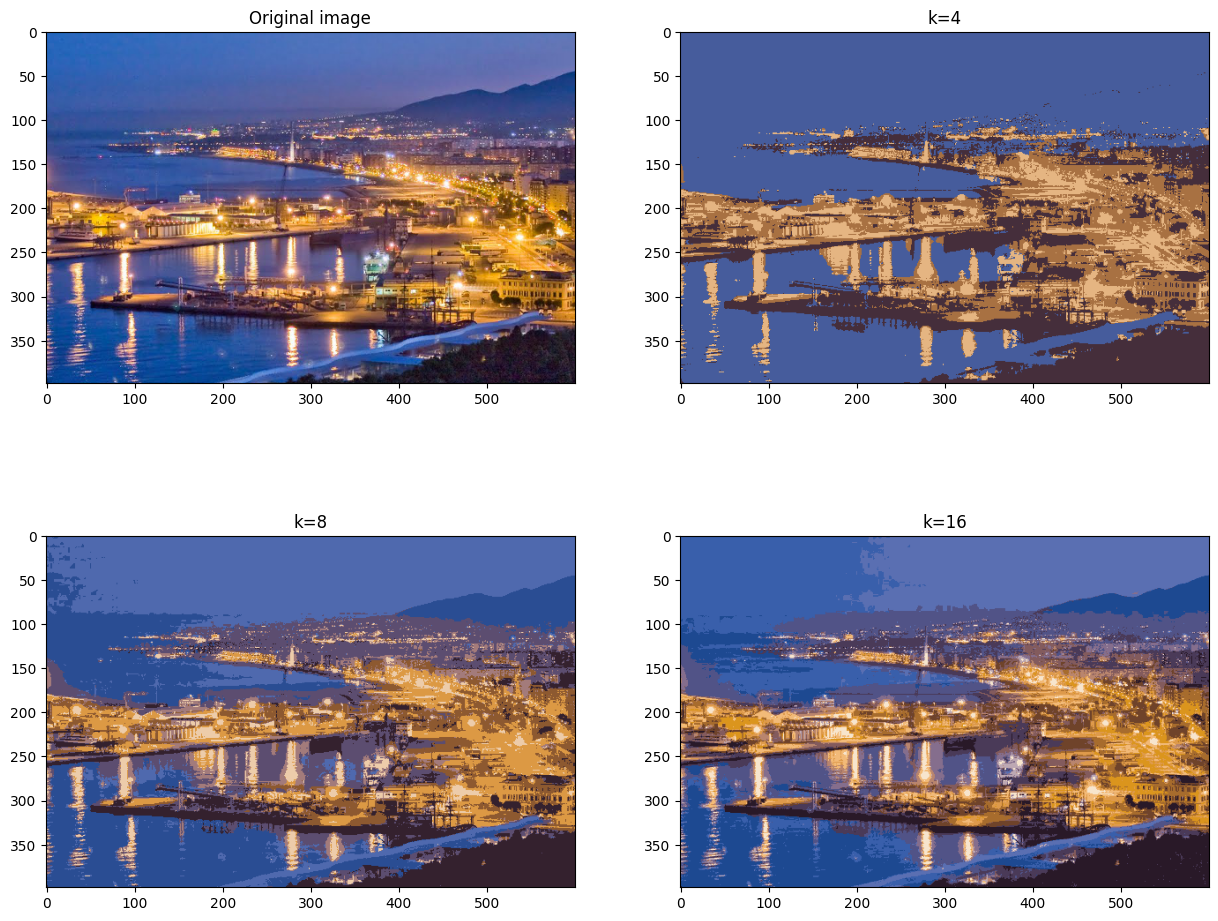

In [9]:
# Assignment 1
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)

# Read RGB image
image = cv2.imread(images_path + "malaga.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Flatten image
flattened_img = image.reshape((-1,3)) # -1 para aplanar, y 3 para mantener los canales RGB
flattened_img = np.float32(flattened_img)

# Set criteria
it = 10
epsilon = 0.2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, it, epsilon)

# Apply k-means. Keep the third argument as None!
_,label4,center4=cv2.kmeans(flattened_img,4,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
_,label8,center8=cv2.kmeans(flattened_img,8,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
_,label16,center16=cv2.kmeans(flattened_img,16,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)

# Colour resultant labels
center4 = np.uint8(center4)
center8 = np.uint8(center8)
center16 = np.uint8(center16)

# Get the color (center) assigned to each pixel
res4 = center4[label4.flatten()]
res8 = center8[label8.flatten()]
res16 = center16[label16.flatten()]

# Reshape to original shape
quantized4 = res4.reshape((image.shape))
quantized8 = res8.reshape((image.shape))
quantized16 = res16.reshape((image.shape))

# Show original image
plt.subplot(2,2,1)
plt.title("Original image")
plt.imshow(image)

# Show k=4
plt.subplot(2,2,2)
plt.title("k=4")
plt.imshow(quantized4)

# Show k=8
plt.subplot(2,2,3)
plt.title("k=8")
plt.imshow(quantized8)

# Show k=16
plt.subplot(2,2,4)
plt.title("k=16")
plt.imshow(quantized16);

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now, **answer the following questions**:

- What `cv2.kmeans()` is doing in each iteration?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>En cada iteración, para cada pixel se calcula la distancia a todos los centroides m_k y se asigna al cluster K del centroide m_k más cercano. Posteriormente se recalcula para cada centroide m_k su nueva posición en base a la media de todos los pixeles asignados al cluster K de ese centroide m_k. El proceso se repite hasta que los centroides se "estabilizen" (cambio menor que epsilon) o hasta que se alcance el número máximo de iteraciones.</i></p>

- What number of maximum iterations did you use? Why?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>En este caso se han usado un número máximo de 10 iteraciones, ya que proporciona una buena convergencia sin un costo computacional excesivo aportando además un buen resultado.</i></p>
    
- How could we compress these images so they require less space in memory? *Note: consider that a pixel in RGB needs 3 bytes to be represented, 8 bits per band.*
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Podríamos comprimir las imagenes siguiendo un enfoque de cuantización de color, es decir, usando menos bits para cada pixel al reducir la cantidad de colores. Cuando usamos k-means, cada cluster representa una región de color en la imagen, entonces si tenemos 4 clusters, solo necesitaremos 2 bits por canal de color para codificar a qué cluster pertenece cada pixel (2^2 = 4), lo que da 6 bits en total (2 bits *3 canales), en lugar de los 24 que teniamos inicialmente. Si tuvieramos 8 clusters serían necesarios 3 bits por canal (2^3 = 8), totalizando tendríamos 9 bits por pixel, que sigue siendo bastante menos que 24, y así sucesivamente a mayor número de clusters.  </i></p>   

###  **<span style="color:green"><b><i>Analyzing execution times</i></b></span>**

In this exercise you are asked to compare the execution time of K-means in a grayscale image, with K-means in a RGB image. Use the image `malaga.png` for this task, and use the same number of clusters and criteria for both, the grayscale and the RGB images.

*Tip: [how to measure execution time in Python](https://stackoverflow.com/questions/14452145/how-to-measure-time-taken-between-lines-of-code-in-python)*

In [11]:
import time

print("Measuring the execution time needed for ...")

K = 2

# Read images
image = cv2.imread(images_path + "malaga.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Set criteria
it = 10
epsilon = 0.2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, it, epsilon)

start = time.process_time() # Start timer

# Flatten image
flattened_img = image.reshape((-1,3))
flattened_img = np.float32(flattened_img)

# Apply k-means
_,label,center=cv2.kmeans(flattened_img,K,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)

print("K-means in the RGB image:", round(time.process_time() - start,5), "seconds") # Stop timer

start = time.process_time() # Start timer

# Flatten image
flattened_img = gray.reshape((-1,1))
flattened_img = np.float32(flattened_img)

# Apply k-means
_,label,center=cv2.kmeans(flattened_img,K,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)

print("K-means in the grayscale image:", round(time.process_time() - start,5), "seconds") # Stop timer

Measuring the execution time needed for ...
K-means in the RGB image: 1.67188 seconds
K-means in the grayscale image: 0.9375 seconds


## 5.2.2 Expectation-Maximization (EM) <a id="522"></a>

**Expectation-Maximization (EM)** is the generalization of the K-means algorithm, where each cluster is represented by a Gaussian distribution, parametrized by a mean and a covariance matrix, instead of just a centroid. It's a *soft clustering* since it doesn't give *hard* decisions where a pixel belongs or not to a cluster, but the probability of that pixel belonging to each cluster $C_j$, that is, $p(x|C_j) \sim N(\mu_j,\Sigma_j)$. This implies that at each algorithm iteration not just the mean of each cluster is refined (as in K-means), but also their covariance matrices.

Before going into detail on the theory behind EM, it is worth seeing how it performs in the car plate problem. OpenCV provides a class implementing the needed functionality for applying EM segmentation to an image, called [`cv2.ml.EM()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html). All methods and parameters are fully detailed in the documentation, so it is a good idea to take a look at it.

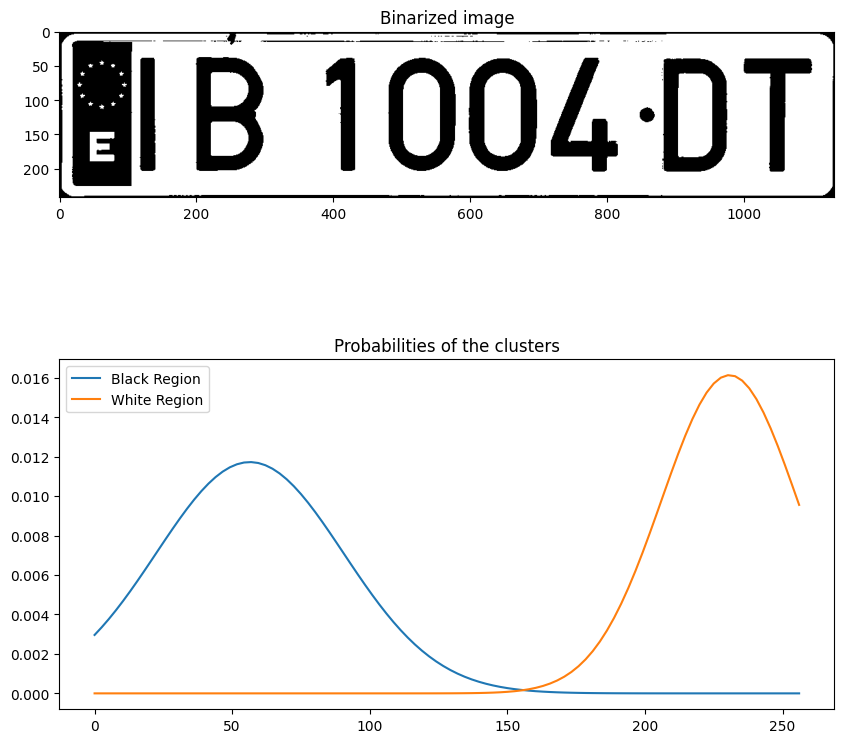

In [12]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
cv2.setRNGSeed(5)

# Define parameters
n_clusters = 2 
covariance_type = 0 # 0: covariance matrix spherical. 1: covariance matrix diagonal. 2: covariance matrix generic
n_iter = 10
epsilon = 0.2

# Create EM empty object
em = cv2.ml.EM_create()

# Set parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n_iter, epsilon)
em.setClustersNumber(n_clusters)
em.setCovarianceMatrixType(covariance_type)
em.setTermCriteria(criteria)

# Read grayscale image
image = cv2.imread(images_path + "plate.jpg",0)

# Flatten image
flattened_img = image.reshape((-1,1))
flattened_img = np.float32(flattened_img)

# Apply EM
_, _, labels, _ = em.trainEM(flattened_img)

# Reshape labels to image size (binarization)
binarized = labels.reshape((image.shape))

# Show original image
plt.subplot(2,1,1)
plt.title("Binarized image")
plt.imshow(binarized, cmap="gray")

# --------------- Gaussian visualization ---------------

plt.subplot(2,1,2)
plt.title("Probabilities of the clusters")

# Get means and covs (for grayscale 1D both)
means = em.getMeans()
covs = em.getCovs()

# Get standard deviation as numPy array
sigmas = np.sqrt(covs)
sigmas = sigmas[:,0,0]

# Cast list to numPy array
means = np.array(means)[:,0]

# Plot Gaussians
x = np.linspace(0, 256, 100)
plt.plot(x, stats.norm.pdf(x, loc = means[0], scale = sigmas[0]))
plt.plot(x, stats.norm.pdf(x, loc = means[1], scale = sigmas[1]))
plt.legend(['Black Region', 'White Region'])

plt.show()

As you can see, although in OpenCV k-means is implemented as a method and EM as a class, they operate in a similar way. In the example above, we are segmenting a car plate into two clusters, and **each cluster is defined by a Gaussian distribution** (a Gaussian distribution for the black region, and another one for the white region). This is the basis of EM, **but how it works**?  

EM is an iterative algorithm that is divided into two main steps:

- First of all, it **initializes the mean and covariance matrix of each of the $K$ clusters**. Typically, it picks at random ($\mu_j$,$\Sigma_j$) and $P(C_j)$ (prior probability) for each cluster $j$.
- Then, it keeps iterating doing Expectation-Maximization steps until some stopping criteria is satisfied (e.g. when no change occurs in a complete iteration):$\\[1pt]$
    1. **Expectation step:** calcule the probabilities of every point belonging to each cluster, that is $p(C_j|x_i), \forall i \in data$:
    $$P(C_j|x_i)=\frac{p(x_i|C_j)p(C_j)}{p(x_i)}=\frac{p(x_i|C_j)p(C_j)}{\sum_i P(x_i|C_j)p(C_j)}$$
    
    assign $x_i$ to the cluster $C_j$ with the highest probability $P(C_j|x_i)$.$\\[10pt]$
    2. **Maximization step:** re-estimate the cluster parameters (($\mu_j$,$\Sigma_j$) and $p(C_j)$) for each cluster $j$ knowing the expectation step results, which is also called *Maximum Likelihood Estimate* (MLE):
$$\mu_j=\frac{\sum_i p(C_j|x_i)x_i}{\sum_i p(C_j|x_i)}$$ $\\[5pt]$
$$\sum_j = \frac{\sum_i p(C_j|x_i)(x_i-\mu_j)(x_i-\mu_j)^T}{\sum_i p(C_j|x_i)}$$$\\[5pt]$
$$p(C_j)=\sum_i p(C_j|x_i)p(x_i)=\frac{\sum_i p(C_j|x_i)}{N}$$    
    Note that if no other information is available, the priors are considered equally probable.
    
<center>
    <img src="./images/em.gif" width="400" align="center">
    <figcaption>Fig 4. Example of an execution of the EM algorithm with two clusters, with details about the evolution of their associated Gaussian distributions.</figcaption>
</center>$\\[5pt]$


Doesn't it remind you to the K-means algorithm? **What is the difference between them?** 

The main difference is that K-means employs the **euclidian distance** to measure how near is a point to a cluster. In EM we use a distance in which **each dimension is weighted** by the **covariance matrix** of each cluster, which is also called **Mahalanobis distance**. Furthermore, for k-means a point of data **belongs or not to** a cluster, in EM a point of data have a higher or lower **probability** to belong to a cluster. The table below summarizes other differences:

<table width="500px">
    <tr>
        <td style="text-align:center;"></td>
        <td style="text-align:center;"><b>K-means</b></td>
        <td style="text-align:center;"><b>EM</b></td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Cluster representation</b></td>
        <td style="text-align:center;">Mean</td>
        <td style="text-align:center;">Mean, (co)variance</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Cluster initialization</b></td>
        <td style="text-align:center;">Randomly select K means</td>
        <td style="text-align:center;">Initialize K Gaussian <br />distributions ($\mu_j$,$\Sigma_j$) and $P(C_j)$</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Expectation:</b> <br />
Estimate the cluster of each data</td>
        <td style="text-align:center;">Assign each point to the closest mean </td>
        <td style="text-align:center;">Compute $P(C_j|x_i)$</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Maximization:</b> <br /> Re-estimate the cluster parameters</td>
        <td style="text-align:center;">Compute means of current clusters</td>
        <td style="text-align:center;">Compute new ($\mu_j,\Sigma_j$), $P(C_j)$ for each cluster $j$</td>
    </tr>
</table>

If you still curious about EM, you can find [here](https://www.youtube.com/watch?v=REypj2sy_5U) a more detailed explanation.

#### <font color="orange">OpenCV pill</font>

Going back to code, working with EM we have to specify a covariance matrix type using [`em.setCovarianceMatrixType()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#a8b383c62697eac9a972931674790f6cd). Also, when you applying [`em.trainEM()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#a5a6a7badbc0c85a8c9fa50a41bf1bcd2) it doesn't return the centroid of the clusters, it is possible to get them calling [`em.getMeans()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#acec62dd55c06711c81d741c2d96603d1). 

### **<span style="color:green"><b><i>ASSIGNMENT 2: Color quantization with YCrCb color space</i></b></span>**

In the next example, color quantization is realized using the YCrCb color space instead of RGB. Recall that you have more info about such a space available in [Apendix 12.2 Color spaces](../Chapter%2012.%20Appendices/12.2%20Color%20spaces.ipynb). In this way, color quantization is only applied to the two color bands Cr and Cb, neglecting the grayscale one Y. 

Notice that in this case, the feature space has 2 dimensions, one for the Cr band, and another dimension for the Cb, hence the feature vector describing the $i^{th}$ pixel results $x_i = [Cr_i,Cb_i]$. 

Let's see how it works!

**What to do?** Test and understand the following code.

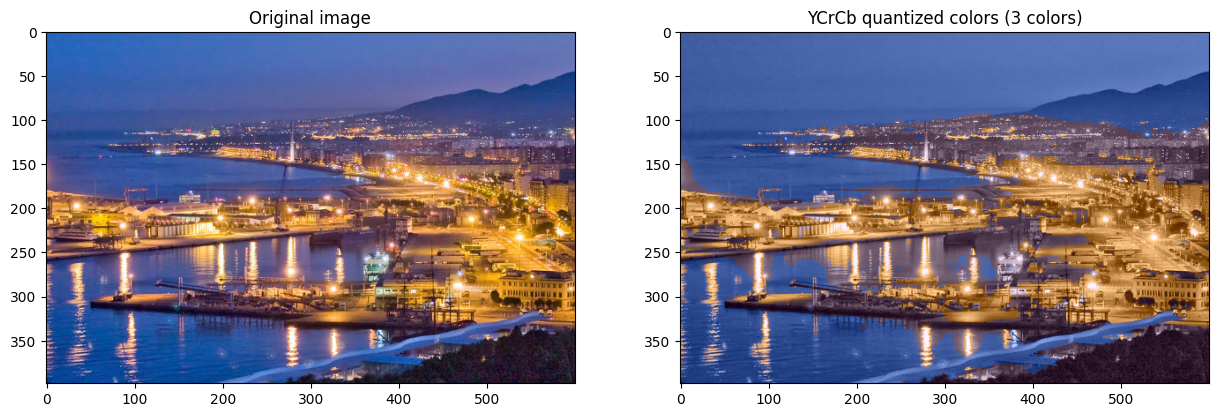

In [13]:
# Assignment 2
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
cv2.setRNGSeed(5)

# Define parameters

n_clusters = 3 # Don't modify this parameter for this exercise

covariance_type = 1 # 0: Spherical covariance matrix. 1: Diagonal covariance matrix. 2: Full covariance matrix
n_iter = 10
epsilon = 0.2

# Create EM empty object
em = cv2.ml.EM_create()

# Set parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n_iter, epsilon)
em.setClustersNumber(n_clusters)
em.setCovarianceMatrixType(covariance_type)
em.setTermCriteria(criteria)

# Read color image
image = cv2.imread(images_path + "malaga.png")

# Convert to YCrCb
image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

# Take color bands (2 lasts)
color_bands = image[:,:,1:3]

# Flatten image
flattened_img = color_bands.reshape((-1,2))
flattened_img = np.float32(flattened_img)

# Apply EM
_, _, labels, _ = em.trainEM(flattened_img)

# Colour resultant labels
centers = em.getMeans()
centers = np.uint8(centers)
res = centers[labels.flatten()]

# Reshape to original shape
color_bands = res.reshape((image.shape[0:2]) + (2,))

# Merge original first band with quantized color bands
quantized = np.zeros(image.shape)
quantized[:,:,0] = image[:,:,0]
quantized[:,:,[1,2]] = color_bands

# Cast to unsigned data dype
quantized = np.uint8(quantized)

# Reconvert to RGB
quantized_rgb = cv2.cvtColor(quantized, cv2.COLOR_YCrCb2RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)

# Show original image
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(image_rgb)

# Show resultant image
plt.subplot(1,2,2)
plt.title("YCrCb quantized colors (3 colors)")
plt.imshow(quantized_rgb);

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

Once you understanded the code above, **answer the following questions:**

- What are the dimensions of the means $u_j$ and the covariance matrices $\Sigma_j$?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>La imagen en color se convierte al espacio YCrCb, y cada pixel de la imagen ahora se describe usando dos valores: Cr y Cb. Entonces, cada píxel tiene dos características (Cr y Cb), por tanto la media $u_j$ es un vector de dimensión 2, que se representa como un vector (1,2) y la matriz de covarianza $\Sigma_j$ tiene tamaño (2,2).</i></p>
    
- What are the dimensions of the input to `trainEM()`? Why?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Se usa "flattened_img = color_bands.reshape((-1, 2))", donde -1 indica que los píxeles se agrupan en una única dimensión. Después del aplanado,flattened_img tiene dimensiones (H×W,2), donde HxW representa el número total de pixeles y 2 las dos características (Cr y Cb) para cada pixel.</i></p>

- Why are the obtained results so good using only 3 clusters?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Al tener solo en cuenta los canales Cr y Cb y omitir la luminancia (Y), el modelo se enfoca en las diferencias de color en la imagen sin ser influenciado por los cambios en la intensidad de luz. Por lo tanto, incluso con solo 3 clusters, se obtiene una segmentación de color eficiente y visualmente coherente.</i></p>
    
- What compression would be better in terms of space in memory, a 16-color compression in a RGB image (that is, each band uses 16 different colors instead of the original 256) or a 4-color compression in a YCrCb image? *Hint: consider the bits needed to codify such information. Hint 2: the grayscale band in YCrCb, that is, Y, is not compressed.*
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   

### Diving deeper into covariance matrices

There are 3 types of covariance matrices: **spherical covariances**, **diagonal covariances** or **full covariances**: $\\[10pt]$

<center>
<img src="./images/ellipses.png" width="700" align="center">
    <figcaption>Fig 5. Examples of different types of covariance matrices.</figcaption>$\\[10pt]$ 
</center>
 

###  **<span style="color:green"><b><i>ASSIGNMENT 3: Visualizing clusters from EM</i></b></span>**

Next, you have a code for visualizing the clusters in the YCrCb color space using EM.  

**What to do?** Run the previous example modifying the type of covariance in the EM algorithm and visualize the changes using the following code.

In [ ]:
# Assignment 3
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

# Get means (2D) and covariance matrices (2x2)
means = np.array(em.getMeans())
covs = np.array(em.getCovs())

# Create figure
fig, ax = plt.subplots()
plt.axis([16, 240, 16, 240])

# Get points contained in each cluster
cluster_1 = np.any(color_bands == np.unique(res,axis=0)[0,:],axis=2)
cluster_2 = np.any(color_bands == np.unique(res,axis=0)[1,:],axis=2)
cluster_3 = np.any(color_bands == np.unique(res,axis=0)[2,:],axis=2)
cluster_1 = image[cluster_1]
cluster_2 = image[cluster_2]
cluster_3 = image[cluster_3]

# Plot them
plt.plot(cluster_1[:,1],cluster_1[:,2],'go')
plt.plot(cluster_2[:,1],cluster_2[:,2],'ro')
plt.plot(cluster_3[:,1],cluster_3[:,2],'bo')

# Plot ellipses representing covariance matrices
PlotEllipse(fig, ax, np.vstack(means[0,:]), covs[0,:,:], 2, color='black')
PlotEllipse(fig, ax, np.vstack(means[1,:]), covs[1,:,:], 2, color='black')
PlotEllipse(fig, ax, np.vstack(means[2,:]), covs[2,:,:], 2, color='black')

fig.canvas.draw()

### <font color="blue"><b><i>Thinking about it (3)</i></b></font>

**Answer the following questions** about how clustering works in EM:

- What are the differences between each type of covariance?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- What type of covariance makes EM equivalent to k-means?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   

### **<span style="color:green"><b><i>ASSIGNMENT 4: Applying EM considering different color spaces</i></b></span>**

It's time to show what you have learned about **EM** and **color spaces**!

**What is your task?** You are asked to **compare color quantization in a RGB color space and in a YCrCb color space**.

For that:
- apply Expectation-Maximization to `malaga.png` using 4 clusters (colors) to both the RGB-space image and the YCrCb-space one,
- and display both results along with the original image.

<font color='blue'>**Expected output:**  </font>

<img src="images/exercise2.png" width="800"/>

In [ ]:
# Assignment 4
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
cv2.setRNGSeed(5)

# Define parameters
n_clusters = 4
covariance_type = 2 # 0: covariance matrix spherical. 1: covariance matrix diagonal. 2: covariance matrix generic
n_iter = None
epsilon = None

# Create EM empty objects
em = cv2.ml.EM_create()

# Set parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n_iter, epsilon)

em.setClustersNumber(n_clusters)
em.setCovarianceMatrixType(covariance_type)
em.setTermCriteria(criteria)

# Read image
image = cv2.imread(images_path + "malaga.png")

# Convert image to RGB
image_RGB = cv2.cvtColor(image, None)

# Convert image to YCrCb
image_YCrCb = cv2.cvtColor(image, None)

# Flatten RGB image
flattened_RGB = image_RGB.reshape((None,None))
flattened_RGB = np.float32(flattened_RGB)

# Flatten color bands of YCrCb image
color_bands_YCrCb = image_YCrCb[:,:,1:3]
flattened_YCrCb = color_bands_YCrCb.reshape((None,None))
flattened_YCrCb = np.float32(flattened_YCrCb)

# Apply EM and get centers of clusters
_, _, labels_RGB, _ = em.trainEM(None)
centers_RGB = em.getMeans()
centers_RGB = np.uint8(centers_RGB)

_, _, labels_YCrCb, _ = em.trainEM(None)
centers_YCrCb = em.getMeans()
centers_YCrCb = np.uint8(centers_YCrCb)

# Colour resultant labels
res_RGB = centers_RGB[labels_RGB.flatten()]
res_YCrCb = centers_YCrCb[labels_YCrCb.flatten()]

# Reshape to original shape
quantized_RGB = res_RGB.reshape((image.shape))
quantized_colors_YCrCb = res_YCrCb.reshape((image.shape[0:2]) + (2,))

# Merge original first band with quantized color bands for YCrCb image
quantized_YCrCb = np.zeros(image.shape)
quantized_YCrCb[:,:,0] = image_YCrCb[:,:,0]
quantized_YCrCb[:,:,[1,2]] = quantized_colors_YCrCb

# Cast YCrCb image to unsigned data dype
quantized_YCrCb = np.uint8(quantized_YCrCb)

# Reconvert YCrCb image back to RGB
quantized_YCrCb = cv2.cvtColor(quantized_YCrCb, cv2.COLOR_YCrCb2RGB)

# Show original image
plt.subplot(2,2,1)
plt.title("Original image")
plt.imshow(None)

# Show resultant quantization using RGB color space
plt.subplot(2,2,2)
plt.title("Quantized colors using RGB color space")
plt.imshow(None)

# Show resultant quantization using YCrCb color space
plt.subplot(2,2,4)
plt.title("Quantized colors using YCrCb color space")
plt.imshow(None);

## Conclusion

Congratulations for getting this work done! You have learned:

- how k-means clustering works and how to use it,
- how EM algorithm performs and how to employ it,
- how to carry out color quantization and the importance of color spaces in this context, and
- some basics for image compression.

### **<span style="color:green"><b><i>OPTIONAL</i></b></span>**

You have used YCrCb in this notebook because you were already fimiliar with it. The truth is that, in color quantization matters, [Lab color space](https://en.wikipedia.org/wiki/CIELAB_color_space) is commonly used.  

Surf the internet for information about the Lab color space and then **answer the following questions**:

- How does Lab color space work?
- Why is it typically used for color quantization?

### **<span style="color:green"><b><i>END OF OPTIONAL PART</i></b></span>**

## References

<a name="myfootnote1">[1]</a>: Borenstein, Eran, Eitan Sharon, and Shimon Ullman. [Combining top-down and bottom-up segmentation.](http://www.wisdom.weizmann.ac.il/~vision/courses/2006_2/papers/recog_seg/Borenstein%20combining%20top-down%20and%20bottom-up%20segmentation.pdf). IEEE Conference on Conference on Computer Vision and Pattern Recognition Workshop, 2004.